In [2]:
'''
Student Names + (IDs): 

Abdelrahman Mohamed Kamal Abdelaziz (1220255)
Mazen Ahmed Fouad Abdelwahab (1220269)
Mohamed Hesham Ibrahim Hassanain (1220278)
Ahmed Walaa Abdlelkhalek Abdelrahman (1220216)

'''
#Import(s)
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
from skimage.feature import canny
from skimage.filters import sobel
from skimage.color import rgb2gray

In [3]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

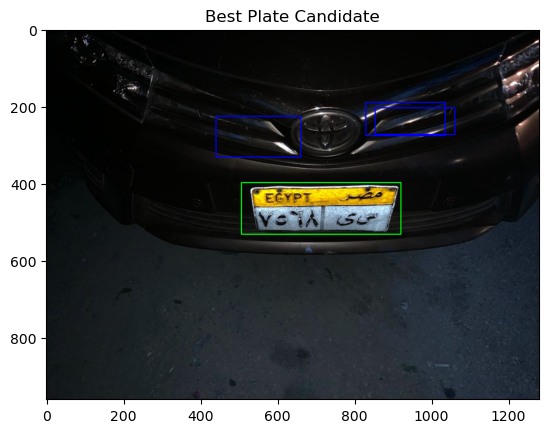

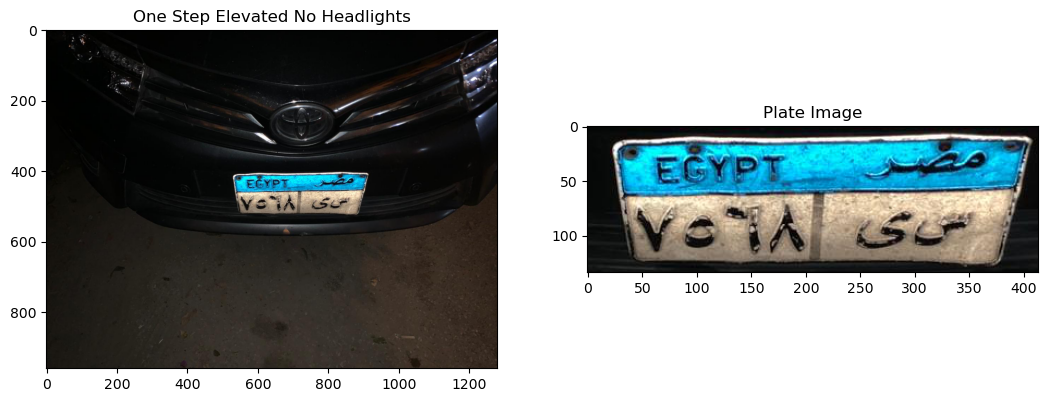

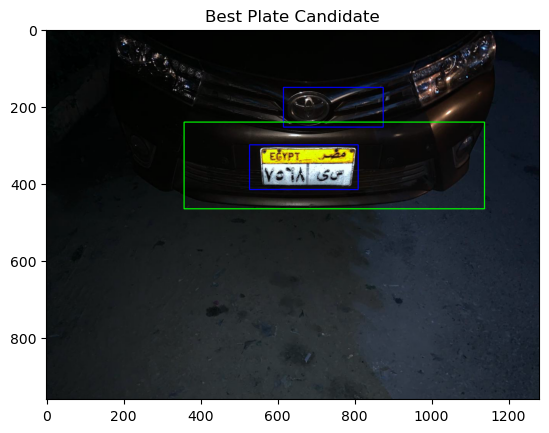

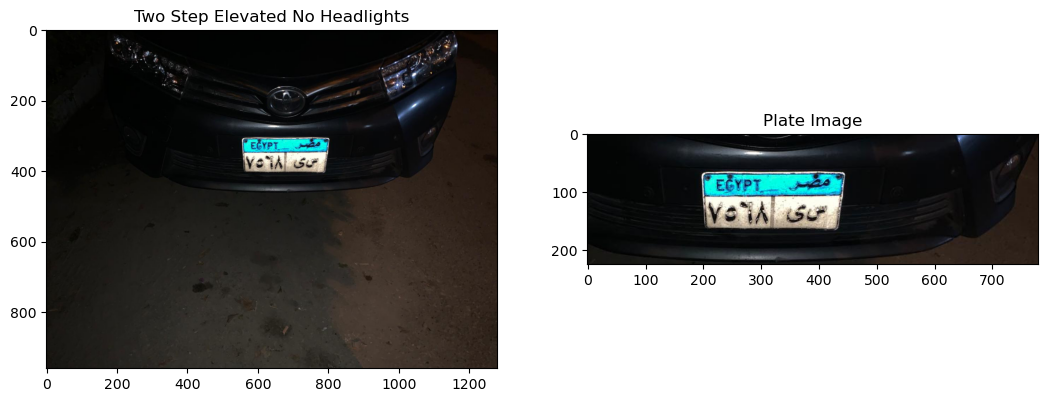

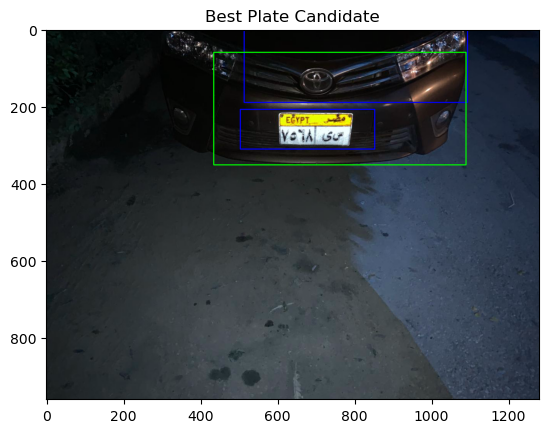

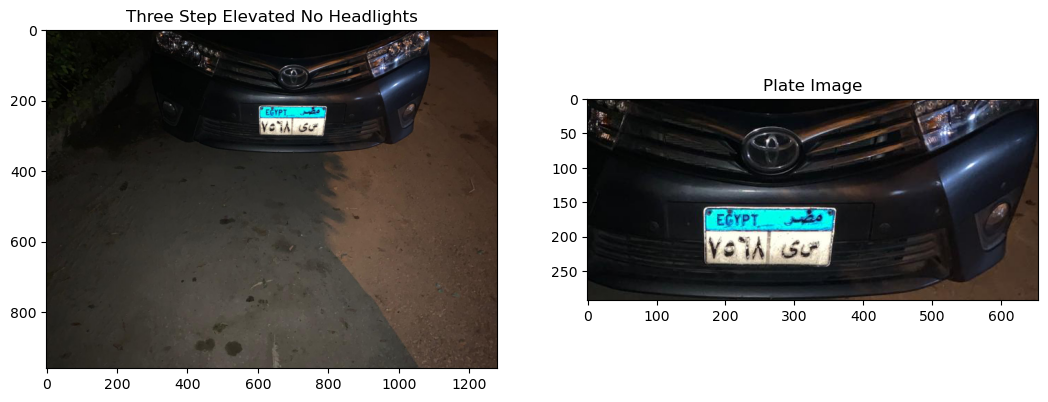

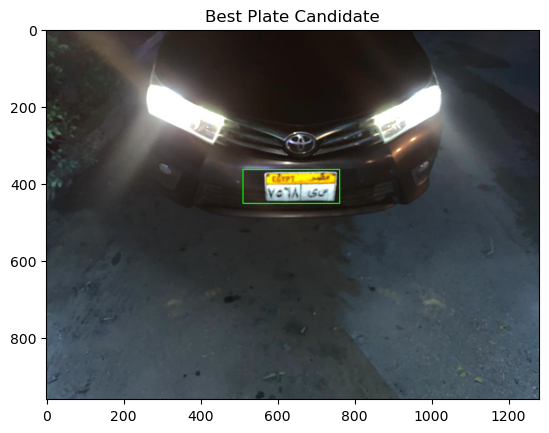

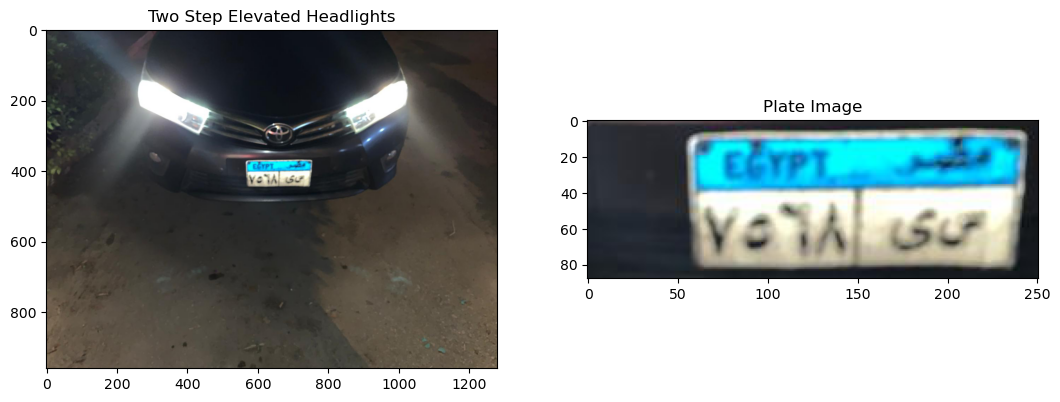

In [4]:
# Plate Localization

#-------------------------------------------------------------------------------------------------------------------------------

Path1 = 'Localization Test/One Step All Angles No Headlights/Straight.jpeg'
Path2 = 'Localization Test/Two Step All Angles No Headlights/Straight.jpeg'
Path3 = 'Localization Test/Three Step All Angles No Headlights/Straight.jpeg'
Path4 = 'Localization Test/One Step All Angles With Headlights/Straight.jpeg'
Path5 = 'Localization Test/Two Step All Angles With Headlights/Straight.jpeg'

Path11 = 'Localization Test/One Step All Angles No Headlights/Elevated.jpeg'
Path12 = 'Localization Test/Two Step All Angles No Headlights/Elevated.jpeg'
Path13 = 'Localization Test/Three Step All Angles No Headlights/Elevated.jpeg'
Path14 = 'Localization Test/One Step All Angles With Headlights/Elevated.jpeg'
Path15 = 'Localization Test/Two Step All Angles With Headlights/Elevated.jpeg'

Path111 = 'Localization Test/One Step All Angles No Headlights/Slight Right.jpeg'
Path112 = 'Localization Test/Two Step All Angles No Headlights/Slight Right.jpeg'
Path113 = 'Localization Test/Three Step All Angles No Headlights/Slight Right.jpeg'
Path114 = 'Localization Test/One Step All Angles With Headlights/Right.jpeg'
Path115 = 'Localization Test/Two Step All Angles With Headlights/Right.jpeg'

Path1111 = 'Localization Test/One Step All Angles No Headlights/Slight Left.jpeg'
Path1112 = 'Localization Test/Two Step All Angles No Headlights/Slight Left.jpeg'
Path1113 = 'Localization Test/Three Step All Angles No Headlights/Slight Left.jpeg'
Path1114 = 'Localization Test/One Step All Angles With Headlights/Left.jpeg'
Path1115 = 'Localization Test/Two Step All Angles With Headlights/Left.jpeg'

Path11111 = 'Localization Test/One Step All Angles No Headlights/Extreme Left.jpeg'
Path11112 = 'Localization Test/One Step All Angles No Headlights/Extreme Right.jpeg'
Path11113 = 'Localization Test/Two Step All Angles No Headlights/Extreme Left.jpeg'
Path11114 = 'Localization Test/Two Step All Angles No Headlights/Extreme Right.jpeg'
Path11115 = 'Localization Test/Three Step All Angles No Headlights/Extreme Left.jpeg'
Path11116 = 'Localization Test/Three Step All Angles No Headlights/Extreme Right.jpeg'

#-------------------------------------------------------------------------------------------------------------------------------

def refine_plate_roi(roi_rgb):
    """
    Refine the rough detected region to a tighter plate crop.
    roi_rgb: cropped region from Original_Img (RGB from skimage.io)
    """
    # Convert RGB -> gray
    roi_gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)

    h, w = roi_gray.shape[:2]
    if h < 10 or w < 10:
        return roi_rgb  # too small to refine

    # Enhance and find edges
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    roi_clahe = clahe.apply(roi_gray)
    roi_blur = cv2.GaussianBlur(roi_clahe, (3, 3), 0)
    edges = cv2.Canny(roi_blur, 50, 150)

    # Slight dilation to connect fragmented edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    edges_dil = cv2.dilate(edges, kernel, iterations=1)

    contours, _ = cv2.findContours(edges_dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_box = None
    best_score = -1.0
    roi_area = float(h * w)

    # ---- 1) Find best inner plate-like box (similar to what you had) ----
    for cnt in contours:
        x, y, cw, ch = cv2.boundingRect(cnt)
        if cw <= 0 or ch <= 0:
            continue

        aspect = cw / float(ch)
        area = cw * ch
        area_ratio = area / roi_area

        # Heuristics inside ROI:
        # - Plate is fairly wide vs tall
        # - Not too tiny, not almost whole ROI
        if not (1.8 <= aspect <= 3.7):
            continue
        if not (0.15 <= area_ratio <= 0.9):
            continue

        # Score by edge density
        sub_edges = edges_dil[y:y+ch, x:x+cw]
        non_zero = cv2.countNonZero(sub_edges)
        density = non_zero / float(area)

        if density > best_score:
            best_score = density
            best_box = (x, y, cw, ch)

    # nothing better found -> return original ROI
    if best_box is None:
        return roi_rgb

    x, y, cw, ch = best_box

    # ---- 2) Aspect-based vertical trimming using Egyptian plate ratio ----
    # Real Egyptian plate: 35cm x 17cm -> aspect ~ 2.06 (w/h)
    ideal_aspect = 35.0 / 17.0

    # If the box is "too tall" (aspect < ~1.7), it likely includes bumper.
    current_aspect = cw / float(ch)

    # We will trim vertically to get closer to the ideal aspect,
    # but we choose the vertical band with the highest edge energy.
    if current_aspect < 1.7:
        # target height for ideal aspect
        target_h = int(cw / ideal_aspect)
        target_h = max(10, min(target_h, ch))  # clamp

        sub_edges_full = edges_dil[y:y+ch, x:x+cw]
        row_sum = sub_edges_full.sum(axis=1)  # edge energy per row

        # sliding window over rows to find the band of height target_h
        best_row_start = 0
        best_row_score = -1

        # if target_h == ch we skip trimming; else search
        if target_h < ch:
            # compute cumulative sum to make sliding window O(n)
            cumsum = np.cumsum(row_sum)
            # score for rows [i, i+target_h) = cumsum[i+target_h-1] - (cumsum[i-1] if i>0 else 0)
            for i in range(0, ch - target_h + 1):
                j = i + target_h - 1
                window_sum = cumsum[j] - (cumsum[i-1] if i > 0 else 0)
                if window_sum > best_row_score:
                    best_row_score = window_sum
                    best_row_start = i

            # now trim the box to that vertical band
            new_y = y + best_row_start
            new_h = target_h

            # final safety clamp
            if new_y + new_h > h:
                new_h = h - new_y

            y = new_y
            ch = new_h

    # ---- 3) Final crop from original ROI ----
    refined = roi_rgb[y:y+ch, x:x+cw]
    return refined

      
#-------------------------------------------------------------------------------------------------------------------------------

def Plate_Detection(image_path):

    # Original Image
    Original_Img = io.imread(image_path)
    Height, Width, _ = Original_Img.shape

    # Read Image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray)

    # Apply Gaussian Blur to reduce noise
    gray_blur = cv2.GaussianBlur(gray_clahe, (5,5), 0)

    # Adaptive Thresholding to handle dark and bright regions
    thresh = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)

    # Morphological closing to connect fragmented regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plate_candidates = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h
        area_ratio = w * h / (Height * Width)
        if (1.8 < aspect_ratio < 3.7) and (0.01 < area_ratio):  # relaxed aspect ratio
            plate_candidates.append((x, y, w, h))

    if not plate_candidates:
        print("No plate candidate found.")
        return None

    # Choose the largest candidate
    plate_candidates = sorted(plate_candidates, key=lambda x: x[2]*x[3], reverse=True)
    for cnt in plate_candidates:
        x, y, w, h = cnt
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Crop the largest candidate
    x, y, w, h = plate_candidates[0]
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    show_images([img], ["Best Plate Candidate"])
    plate_img = Original_Img[y:y+h, x:x+w] 
    
    return plate_img

#-------------------------------------------------------------------------------------------------------------------------------
# Testing the Plate Detection Function on Different Images
#-------------------------------------------------------------------------------------------------------------------------------

# Origignal_Img1 = io.imread(Path1)
# Detected_Plate1 = Plate_Detection(Path1)
# if Detected_Plate1 is not None:
#     # GrayScale = rgb2gray(Detected_Plate1)
#     # BinaryScale = GrayScale > 0.4
#     show_images([Origignal_Img1, Detected_Plate1], ["One Step No Headlights", "Plate Image"])

# Origignal_Img2 = io.imread(Path2)
# Detected_Plate2 = Plate_Detection(Path2)
# if Detected_Plate2 is not None:
#     # GrayScale = rgb2gray(Detected_Plate2)
#     # BinaryScale = GrayScale > 0.4
#     show_images([Origignal_Img2, Detected_Plate2], ["Two Steps No Headlights", "Plate Image"])

# Origignal_Img3 = io.imread(Path3)
# Detected_Plate3 = Plate_Detection(Path3)
# if Detected_Plate3 is not None:
#     # GrayScale = rgb2gray(Detected_Plate3)
#     # BinaryScale = GrayScale > 0.4
#     show_images([Origignal_Img3, Detected_Plate3], ["Three Steps No Headlights", "Plate Image"])

# Origignal_Img4 = io.imread(Path4)
# Detected_Plate4 = Plate_Detection(Path4)
# if Detected_Plate4 is not None:
#     # GrayScale = rgb2gray(Detected_Plate4)
#     # BinaryScale = GrayScale > 0.4
#     show_images([Origignal_Img4, Detected_Plate4], ["One Step Headlights", "Plate Image"])

# Origignal_Img5 = io.imread(Path5)
# Detected_Plate5 = Plate_Detection(Path5)
# if Detected_Plate5 is not None:
#     # GrayScale = rgb2gray(Detected_Plate5)
#     # BinaryScale = GrayScale > 0.4
#     show_images([Origignal_Img5, Detected_Plate5], ["Two Steps Headlights", "Plate Image"])

# #-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img11 = io.imread(Path11)
Detected_Plate11 = Plate_Detection(Path11)
if Detected_Plate11 is not None:
    show_images([Origignal_Img11, Detected_Plate11], ["One Step Elevated No Headlights", "Plate Image"]) 

Origignal_Img12 = io.imread(Path12)
Detected_Plate12 = Plate_Detection(Path12)
if Detected_Plate12 is not None:
    show_images([Origignal_Img12, Detected_Plate12], ["Two Step Elevated No Headlights", "Plate Image"])

Origignal_Img13 = io.imread(Path13)
Detected_Plate13 = Plate_Detection(Path13)
if Detected_Plate13 is not None:
    show_images([Origignal_Img13, Detected_Plate13], ["Three Step Elevated No Headlights", "Plate Image"])

# Origignal_Img14 = io.imread(Path14)
# Detected_Plate14 = Plate_Detection(Path14)
# if Detected_Plate14 is not None:
#     show_images([Origignal_Img14, Detected_Plate14], ["One Step Elevated Headlights", "Plate Image"])

Origignal_Img15 = io.imread(Path15)
Detected_Plate15 = Plate_Detection(Path15)
if Detected_Plate15 is not None:
    show_images([Origignal_Img15, Detected_Plate15], ["Two Step Elevated Headlights", "Plate Image"])

# #-------------------------------------------------------------------------------------------------------------------------------

# Origignal_Img111 = io.imread(Path111)
# Detected_Plate111 = Plate_Detection(Path111)
# if Detected_Plate111 is not None:
#     show_images([Origignal_Img111, Detected_Plate111], ["One Step Slight Right No Headlights", "Plate Image"])

# Origignal_Img112 = io.imread(Path112)
# Detected_Plate112 = Plate_Detection(Path112)
# if Detected_Plate112 is not None:
#     show_images([Origignal_Img112, Detected_Plate112], ["Two Step Slight Right No Headlights", "Plate Image"])

# Origignal_Img113 = io.imread(Path113)
# Detected_Plate113 = Plate_Detection(Path113)
# if Detected_Plate113 is not None:
#     show_images([Origignal_Img113, Detected_Plate113], ["Three Step Slight Right No Headlights", "Plate Image"])

# # Origignal_Img114 = io.imread(Path114)
# # Detected_Plate114 = Plate_Detection(Path114)
# # if Detected_Plate114 is not None:
# #     show_images([Origignal_Img114, Detected_Plate114], ["One Step Slight Right Headlights", "Plate Image"])

# Origignal_Img115 = io.imread(Path115)
# Detected_Plate115 = Plate_Detection(Path115)
# if Detected_Plate115 is not None:
#     show_images([Origignal_Img115, Detected_Plate115], ["Two Step Slight Right Headlights", "Plate Image"])

# #-------------------------------------------------------------------------------------------------------------------------------

# Origignal_Img1111 = io.imread(Path1111)
# Detected_Plate1111 = Plate_Detection(Path1111)
# if Detected_Plate1111 is not None:
#     show_images([Origignal_Img1111, Detected_Plate1111], ["One Step Slight Left No Headlights", "Plate Image"])

# Origignal_Img1112 = io.imread(Path1112)
# Detected_Plate1112 = Plate_Detection(Path1112)
# if Detected_Plate1112 is not None:
#     show_images([Origignal_Img1112, Detected_Plate1112], ["Two Step Slight Left No Headlights", "Plate Image"])

# Origignal_Img1113 = io.imread(Path1113)
# Detected_Plate1113 = Plate_Detection(Path1113)
# if Detected_Plate1113 is not None:
#     show_images([Origignal_Img1113, Detected_Plate1113], ["Three Step Slight Left No Headlights", "Plate Image"])

# # Origignal_Img1114 = io.imread(Path1114)
# # Detected_Plate1114 = Plate_Detection(Path1114)
# # if Detected_Plate1114 is not None:
# #     show_images([Origignal_Img1114, Detected_Plate1114], ["One Step Slight Left Headlights", "Plate Image"])

# Origignal_Img1115 = io.imread(Path1115)
# Detected_Plate1115 = Plate_Detection(Path1115)
# if Detected_Plate1115 is not None:
#     show_images([Origignal_Img1115, Detected_Plate1115], ["Two Step Slight Left Headlights", "Plate Image"])

# #-------------------------------------------------------------------------------------------------------------------------------

# # Original_Img11111 = io.imread(Path11111)
# # Detected_Plate11111 = Plate_Detection(Path11111)
# # if Detected_Plate11111 is not None:
# #     show_images([Original_Img11111, Detected_Plate11111], ["One Step Extreme Left No Headlights", "Plate Image"])

# # Original_Img11112 = io.imread(Path11112)
# # Detected_Plate11112 = Plate_Detection(Path11112)
# # if Detected_Plate11112 is not None:
# #     show_images([Original_Img11112, Detected_Plate11112], ["One Step Extreme Right No Headlights", "Plate Image"])

# Original_Img11113 = io.imread(Path11113)
# Detected_Plate11113 = Plate_Detection(Path11113)
# if Detected_Plate11113 is not None:
#     show_images([Original_Img11113, Detected_Plate11113], ["Two Step Extreme Left No Headlights", "Plate Image"])

# Original_Img11114 = io.imread(Path11114)
# Detected_Plate11114 = Plate_Detection(Path11114)
# if Detected_Plate11114 is not None:
#     show_images([Original_Img11114, Detected_Plate11114], ["Two Step Extreme Right No Headlights", "Plate Image"])

# # Original_Img11115 = io.imread(Path11115)
# # Detected_Plate11115 = Plate_Detection(Path11115)
# # if Detected_Plate11115 is not None:
# #     show_images([Original_Img11115, Detected_Plate11115], ["Three Step Extreme Left No Headlights", "Plate Image"])

# # Original_Img11116 = io.imread(Path11116)
# # Detected_Plate11116 = Plate_Detection(Path11116)
# # if Detected_Plate11116 is not None:
# #     show_images([Original_Img11116, Detected_Plate11116], ["Three Step Extreme Right No Headlights", "Plate Image"])


# Original_Img11114 = io.imread("image.jpg")
# Detected_Plate11114 = Plate_Detection("image.jpg")
# if Detected_Plate11114 is not None:
#     show_images([Original_Img11114, Detected_Plate11114], ["Two Step Extreme Right No Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Band bbox: (np.int64(57), 58, np.int64(239), 79)


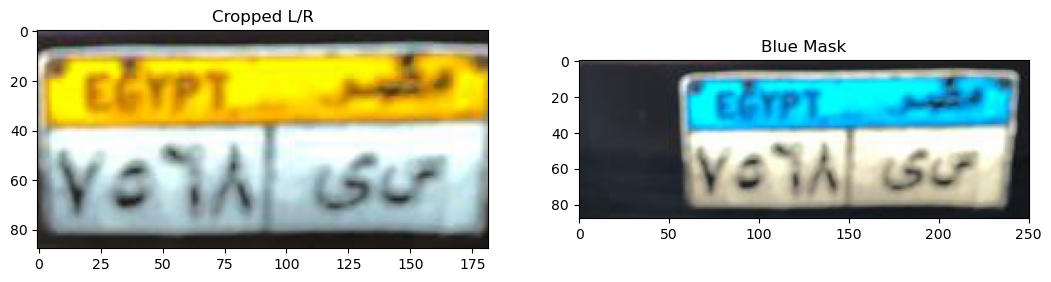

In [5]:
import cv2
import numpy as np

def adaptive_blue_mask(img_bgr, debug=False):
    """
    Returns: mask (0/255) of 'blue-ish' pixels,
             and the chosen lower/upper HSV bounds.
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)

    # 1) Take only reasonably saturated, bright pixels (colored, not gray)
    sat_thresh = 40   # S > 40
    val_thresh = 40   # V > 40
    colored = (S > sat_thresh) & (V > val_thresh)

    # 2) Within colored pixels, take a very WIDE blue-ish hue band
    #    OpenCV H ranges from 0..179 (blue roughly around 100-140, but we'll be generous)
    H_colored = H[colored]
    blue_candidate_mask = (H_colored >= 70) & (H_colored <= 150)
    blue_hues = H_colored[blue_candidate_mask]

    if blue_hues.size == 0:
        # No obvious blue at all
        return np.zeros_like(H, dtype=np.uint8), None, None

    # 3) Histogram of blue hue values → find peak
    hist, bin_edges = np.histogram(blue_hues, bins=36, range=(0, 180))
    peak_bin = np.argmax(hist)
    # Center of that bin:
    h_peak = 0.5 * (bin_edges[peak_bin] + bin_edges[peak_bin + 1])

    # 4) Define tighter bounds around the peak (±delta)
    delta = 15  # width of hue window around peak
    h_low = max(0, int(h_peak - delta))
    h_high = min(179, int(h_peak + delta))

    lower_blue = np.array([h_low, sat_thresh, val_thresh], dtype=np.uint8)
    upper_blue = np.array([h_high, 255, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    if debug:
        print(f"Adaptive blue H range: [{h_low}, {h_high}] (peak at {h_peak:.1f})")

    return mask, lower_blue, upper_blue

def crop_left_right_by_blue_adaptive(img_bgr):
    H, W = img_bgr.shape[:2]

    mask, lb, ub = adaptive_blue_mask(img_bgr)
    if lb is None:
        return None, None, None  # no blue

    # --- vertical band (rows) based on relative maximum ---
    row_counts = mask.sum(axis=1) // 255
    max_row = row_counts.max()
    if max_row == 0:
        return None, None, None

    row_thresh = 0.5 * max_row
    blue_rows = row_counts > row_thresh

    best_start = best_end = None
    cur_start = None
    for y, is_blue in enumerate(blue_rows):
        if is_blue and cur_start is None:
            cur_start = y
        elif not is_blue and cur_start is not None:
            if best_start is None or (y - cur_start) > (best_end - best_start):
                best_start, best_end = cur_start, y
            cur_start = None
    if cur_start is not None:
        y = len(blue_rows)
        if best_start is None or (y - cur_start) > (best_end - best_start):
            best_start, best_end = cur_start, y

    if best_start is None:
        return None, None, None

    y0_band, y1_band = best_start, best_end

    # --- horizontal band (cols) inside that blue band ---
    submask = mask[y0_band:y1_band, :]
    col_counts = submask.sum(axis=0) // 255
    max_col = col_counts.max()
    if max_col == 0:
        return None, None, None

    col_thresh = 0.3 * max_col  # relative, not based on H
    blue_cols = col_counts > col_thresh

    xs = np.where(blue_cols)[0]
    if xs.size == 0:
        return None, None, None

    x0 = xs[0]
    x1 = xs[-1]

    # add margin
    margin = int(0.02 * W)
    x0 = max(0, x0 - margin)
    x1 = min(W - 1, x1 + margin)

    cropped_lr = img_bgr[:, x0:x1]

    return cropped_lr, (x0, y0_band, x1, y1_band), mask


cropped_lr, band_bbox, mask = crop_left_right_by_blue_adaptive(Detected_Plate15)

if cropped_lr is not None:
    x0, y0_band, x1, y1_band = band_bbox
    print("Band bbox:", band_bbox)
    show_images(
        [cv2.cvtColor(cropped_lr, cv2.COLOR_BGR2RGB), Detected_Plate15],
        ["Cropped L/R", "Blue Mask"]
    )



Saved clean_digits.png & clean_letters.png
num_labels (including background): 6
label 0: x=0 y=0 w=239 h=188 area=37915
label 1: x=0 y=0 w=230 h=181 area=3123
label 2: x=0 y=47 w=51 h=70 area=1249
label 3: x=135 y=71 w=76 h=59 area=1152
label 4: x=69 y=73 w=61 h=77 area=1382
label 5: x=96 y=113 w=11 h=13 area=111
plate_area=149760, min_area=748.8000000000001, max_area=37440.0
min_height_px=43.199999999999996, max_height_px=115.2
Found candidate boxes: 7


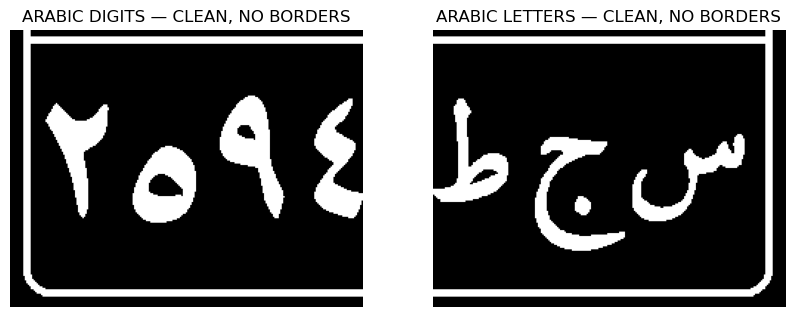

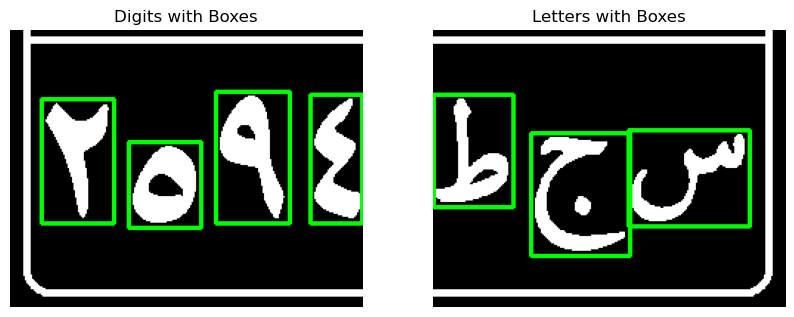

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology
import numpy as np
from skimage import img_as_ubyte


def preprocess_plate_with_smoothing(img, debug=True):
    """
    Preprocess the localized license plate image with:
    - Pre-threshold smoothing (median blur)
    - CLAHE
    - Adaptive thresholding
    - Post-threshold noise removal (morphological opening)
    Returns the final cleaned binary image.
    """
    # ---------------- 1. Convert to grayscale ----------------
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---------------- 2. Optional pre-threshold smoothing ----------------
    # Reduce scattered grayscale noise before thresholding
    gray_smooth = cv2.medianBlur(gray, ksize=3)  # small kernel

    # ---------------- 3. CLAHE ----------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray_smooth)

    # ---------------- 4. Adaptive Threshold ----------------
    H, W = enhanced.shape
    block_size = int(max(15, (H // 7) | 1))  # odd
    C = 8
    binary = cv2.adaptiveThreshold(
        enhanced,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=block_size,
        C=C
    )

    # ---------------- 5. Invert if needed ----------------------------------
    white_ratio = np.mean(binary == 255)
    if white_ratio > 0.55:
        binary = cv2.bitwise_not(binary)

    # ---------------- 6. Post-threshold noise removal ----------------
    # Remove tiny white speckles
    h, w = binary.shape
    k_open = max(1, round(h * 0.015))  # kernel proportional to plate height
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_open, k_open))
    cleaned_binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # ---------------- 7. Debug visualization ----------------
    if debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1,4,1)
        plt.imshow(gray, cmap='gray'); plt.title("Grayscale"); plt.axis("off")
        plt.subplot(1,4,2)
        plt.imshow(gray_smooth, cmap='gray'); plt.title("Median Smoothed"); plt.axis("off")
        plt.subplot(1,4,3)
        plt.imshow(binary, cmap='gray'); plt.title("Adaptive Threshold"); plt.axis("off")
        plt.subplot(1,4,4)
        plt.imshow(cleaned_binary, cmap='gray'); plt.title("After Morph Open"); plt.axis("off")
        plt.show()

    return cleaned_binary


def crop_one_side(img, mask, side, threshold=0.02, max_px=21):
    """
    Crops ONE SIDE ONLY (top, bottom, left, right) by 1px repeatedly.
    Stops when that side becomes clean OR when image would become too small.
    """
    for _ in range(max_px):

        # HARD SAFETY — never allow cropping if too small
        if img.shape[0] < 10 or img.shape[1] < 10:
            break

        if side == "top":
            border_val = mask[0, :].mean()
            if border_val > threshold:
                img  = img[1:, :]
                mask = mask[1:, :]
            else:
                break

        elif side == "bottom":
            border_val = mask[-1, :].mean()
            if border_val > threshold:
                img  = img[:-1, :]
                mask = mask[:-1, :]
            else:
                break

        elif side == "left":
            border_val = mask[:, 0].mean()
            if border_val > threshold:
                img  = img[:, 1:]
                mask = mask[:, 1:]
            else:
                break

        elif side == "right":
            border_val = mask[:, -1].mean()
            if border_val > threshold:
                img  = img[:, :-1]
                mask = mask[:, :-1]
            else:
                break

    return img, mask


def clean_crop(img, mask):
    img, mask = crop_one_side(img, mask, "top")
    img, mask = crop_one_side(img, mask, "bottom")
    img, mask = crop_one_side(img, mask, "left")
    img, mask = crop_one_side(img, mask, "right")
    return img, mask


# ======================================================================
# WHITE BACKGROUND RENDERING
# ======================================================================
def make_clean(region_img, region_mask):
    clean = np.ones_like(region_img)
    clean[region_mask] = region_img[region_mask]
    return clean




def remove_plate_header(plate_img, header_ratio=0.2):

    """
    Crops out the top header rectangle (Egypt / مصر) from a license plate.
    
    Parameters:
        plate_img: binary or grayscale plate image
        header_ratio: proportion of height to remove from top (0.0–1.0)
    
    Returns:
        cropped_img: the plate without the top header
    """
    h, w = plate_img.shape[:2]
    header_height = int(h * header_ratio)
    
    # Keep only the bottom part
    cropped_img = plate_img[header_height:, :]
    
    return cropped_img



def morphological_and_CCL(binary_img,left,right,debug=True):
    """
    Takes the binarized plate image (white foreground, black background)
    and performs:
      - Small opening
      - Small closing
      - Connected Components (8-connectivity)
      - Character plausibility filtering (relative thresholds)
    Returns:
      cleaned_binary, boxes, stats_all, labels, num_labels
    """

    # ---------- STEP 2: Morphological Cleaning ----------
    h, w = binary_img.shape[:2]

    # Kernel sizes scaled to image height
    # k1 = max(1, round(h * 0.01))  # opening kernel
    # k2 = max(1, round(h * 0.025))   # closing kernel

    # kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (k1, k1))
    # kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (k2, k2))

    # # Small opening to remove tiny speckles
    # opened = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel1,iterations=1)

    # # Small closing to fill small holes in characters
    # closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel2,iterations=1)

    # cleaned_binary = closed.copy()

    # # Force binary exact values (0,255) and uint8
    # cleaned_binary = np.where(cleaned_binary > 0, 255, 0).astype(np.uint8)

    # if debug:
    #     print("After morphology: dtype:", cleaned_binary.dtype, "unique:", np.unique(cleaned_binary))
    #     print("White pixel count:", int(np.sum(cleaned_binary == 255)))


    # cropped_plate = remove_plate_header(cleaned_binary, header_ratio=0.45)
    # noborders= remove_white_borders(cleaned_binary)

    
    
    # ---------- STEP 3: Connected Components (8-connectivity) ----------

    left = (left > 0).astype("uint8") * 255
    right = (right > 0).astype("uint8") * 255

    num_labels1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(
        left,
        connectivity=8,
        ltype=cv2.CV_32S
    )
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        right,
        connectivity=8,
        ltype=cv2.CV_32S
    )

    

    if debug:
        print("num_labels (including background):", num_labels)
        # optionally print first few stats
        for i in range(min(num_labels, 12)):
            x,y,wb,hb,area = stats[i]
            print(f"label {i}: x={x} y={y} w={wb} h={hb} area={area}")

    # ---------- STEP 5: Bounding-Box Filtering (RELATIVE thresholds) ----------
    boxesleft = []
    stats_allleft = []
    boxesright = []
    stats_allright = []

    plate_area = h * w

    # Reasonable starting thresholds (relative)
    min_area = plate_area * 0.005   # 0.5% of plate area
    max_area = plate_area * 0.25    # 25% of plate area (likely merged)
    min_aspect = 0.08               # w/h (allow narrow digits)   0.08 
    max_aspect = 1.4                # some letters might be wider than digits

    min_height = h * 0.15           # allow small characters (15% of plate height)
    max_height = h * 0.4

    if debug:
        print(f"plate_area={plate_area}, min_area={min_area}, max_area={max_area}")
        print(f"min_height_px={min_height}, max_height_px={max_height}")

    for label in range(1, num_labels1):  # skip background label 0
        x, y, w_b, h_b, area = stats1[label]
        stats_allleft.append((label, x, y, w_b, h_b, area))

        # area filtering
        if area < min_area:
            continue
        if area > max_area:
            continue  # merged objects (we're skipping splitting per your instruction)

        aspect = w_b / float(max(1, h_b))

        # aspect ratio filtering
        if aspect < min_aspect or aspect > max_aspect:
            continue

        # height filtering
        if h_b < min_height or h_b > max_height:
            continue

        boxesleft.append((x, y, w_b, h_b))
        
    for label in range(1, num_labels):  # skip background label 0
        x, y, w_b, h_b, area = stats[label]
        stats_allright.append((label, x, y, w_b, h_b, area))

        # area filtering
        if area < min_area:
            continue
        if area > max_area:
            continue  # merged objects (we're skipping splitting per your instruction)

        aspect = w_b / float(max(1, h_b))

        # aspect ratio filtering
        if aspect < min_aspect or aspect > max_aspect:
            continue

        # height filtering
        if h_b < min_height or h_b > max_height:
            continue

        boxesright.append((x, y, w_b, h_b))

    if debug:
        print("Found candidate boxes:", len(boxesleft)+len(boxesright))
        # show bounding boxes overlay for quick visual check (returns BGR image)
        dbg = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
        for (x, y, wb, hb) in boxesleft:
            cv2.rectangle(dbg, (x, y), (x+wb, y+hb), (0,255,0), 2)
        dbg2 = cv2.cvtColor(right, cv2.COLOR_GRAY2BGR)
        for (x, y, wb, hb) in boxesright:
            cv2.rectangle(dbg, (x, y), (x+wb, y+hb), (0,255,0), 2)
        # Display inline if desired (plt or cv2.imshow)
        # cv2.imshow("ccl_debug", dbg); cv2.waitKey(0)
        # For notebooks, convert and display with matplotlib:
        try:
            from matplotlib import pyplot as plt
            # plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
            # plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(dbg2, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
        except Exception:
            pass

    # ensure expected number (2–7 components)
    if len(boxesleft)+len(boxesright) < 2 or len(boxesleft)+len(boxesright) > 7:
        print("⚠ Warning: suspicious number of character candidates =", len(boxesleft)+len(boxesright))

    return boxesleft,boxesright,left,right


def draw_components(imgL,imgR, boxesL,boxesR, pad=3):
    """Draws padded bounding boxes on the image for visualization."""
    out = cv2.cvtColor(imgL.copy(), cv2.COLOR_GRAY2BGR)
    H, W = imgL.shape[:2]

    for (x, y, w, h) in boxesL:
        # Expand bounding box
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W - 1, x + w + pad)
        y2 = min(H - 1, y + h + pad)

        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 255, 0), 2)
    out2 = cv2.cvtColor(imgR.copy(), cv2.COLOR_GRAY2BGR)
    H, W = imgR.shape[:2]

    for (x, y, w, h) in boxesR:
        # Expand bounding box
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(W - 1, x + w + pad)
        y2 = min(H - 1, y + h + pad)

        cv2.rectangle(out2, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return out,out2

import cv2
import numpy as np
from matplotlib import pyplot as plt

def _ensure_binary_uint8(img):
    img = np.asarray(img)
    if img.dtype != np.uint8:
        img = (img > 0).astype(np.uint8) * 255
    else:
        # ensure exact 0/255
        img = np.where(img > 0, 255, 0).astype(np.uint8)
    return img




def manual_sort_boxes(boxes):
    """
    Sort boxes by x-coordinate (left-to-right) manually.
    boxes: list of (x, y, w, h)
    returns: sorted list
    """
    sorted_boxes = []

    for box in boxes:
        x = box[0]
        inserted = False
        for i, b in enumerate(sorted_boxes):
            if x < b[0]:
                sorted_boxes.insert(i, box)
                inserted = True
                break
        if not inserted:
            sorted_boxes.append(box)

    return sorted_boxes


def save_characters(characters_sortedL, characters_sortedR):
    """
    Saves sorted character images from digits (left) and letters (right).
    
    Parameters:
        characters_sortedL: list of (x, y, w, h, img) for digits
        characters_sortedR: list of (x, y, w, h, img) for letters
    """
    # Save digits
    for i, (_, _, _, _, img) in enumerate(characters_sortedL):
        cv2.imwrite(f"digit_{i}.png", img)

    # Save letters
    for i, (_, _, _, _, img) in enumerate(characters_sortedR):
        cv2.imwrite(f"letter_{i}.png", img)


def crop_characters(binary_img, boxes, resize_to=(64, 64), pad_ratio=0.09):
    """
    Returns list of tuples: (x, y, w, h, char_img) with padded cropping.
    """
    H, W = binary_img.shape[:2]
    characters = []

    for (x, y, w_b, h_b) in boxes:

        # Compute proportional padding from box size
        pad_x = int(w_b * pad_ratio)
        pad_y = int(h_b * pad_ratio)

        # Apply padded crop
        x1 = max(0, x - pad_x)
        y1 = max(0, y - pad_y)
        x2 = min(W, x + w_b + pad_x)
        y2 = min(H, y + h_b + pad_y)

        char_img = binary_img[y1:y2, x1:x2]

        # Resize if needed
        # if resize_to is not None:
        #     char_img = cv2.resize(char_img, resize_to, interpolation=cv2.INTER_NEAREST)

        characters.append((x, y, w_b, h_b, char_img))

    return characters




img = io.imread("Dataset/Vehicles with unpaid customs.png")[:,:,:3]
# img=plate_crop3
gray = color.rgb2gray(img)

# 1) Crop bottom part (Arabic region)
h = gray.shape[0]
plate = gray[int(h * 0.35):, :]


# 2) Threshold + clean
th = filters.threshold_otsu(plate)
mask = plate < th

mask = morphology.remove_small_objects(mask, 0.1)
mask = morphology.remove_small_holes(mask, 0.1)

# 3) Split halves
H, W = mask.shape
digits_img  = plate[:, :W // 2]
letters_img = plate[:, W // 2:]

digits_mask  = mask[:, :W // 2]
letters_mask = mask[:, W // 2:]


# 4) SAFE crop each half independently
digits_img_c,  digits_mask_c  = clean_crop(digits_img, digits_mask)
letters_img_c, letters_mask_c = clean_crop(letters_img, letters_mask)

# 5) Build final clean images
clean_digits  = make_clean(digits_img_c, digits_mask_c)
clean_letters = make_clean(letters_img_c, letters_mask_c)

# 6) Show results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(digits_mask_c, cmap="gray")
plt.title("ARABIC DIGITS — CLEAN, NO BORDERS")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(letters_mask_c, cmap="gray")
plt.title("ARABIC LETTERS — CLEAN, NO BORDERS")
plt.axis("off")

# 7) Save
io.imsave("clean_digits.png", img_as_ubyte(clean_digits))
io.imsave("clean_letters.png", img_as_ubyte(clean_letters))
print("Saved clean_digits.png & clean_letters.png")

# Straight1 = io.imread('Dataset/image.png')
# image=plate_crop1
# image=Straight1
# proccesded=preprocess_plate_with_smoothing(image)
boxesL, boxesR,leftT,rightT= morphological_and_CCL(img,digits_mask_c,letters_mask_c,debug=True)
# draw_components(leftT,rightT,boxesL,boxesR)

out_digits, out_letters = draw_components(leftT, rightT, boxesL, boxesR)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(out_digits)
plt.title("Digits with Boxes")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(out_letters)
plt.title("Letters with Boxes")
plt.axis("off")
plt.show()

# Sort boxes by x-coordinate
boxes_sortedL = manual_sort_boxes(boxesL)
boxes_sortedR = manual_sort_boxes(boxesR)

# Crop in that order
charimages_sortedL = crop_characters(leftT, boxes_sortedL)
charimages_sortedR = crop_characters(rightT, boxes_sortedR)
save_characters(charimages_sortedL,charimages_sortedR)

In [7]:
'''
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
os.environ['TESSDATA_PREFIX'] = os.path.abspath("Dataset")
# os.environ.pop('TESSDATA_PREFIX', None)
def add_padding(img, pad=10):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

def add_paddingblack(img, pad=200):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

def recognize_arabic_digit(image_path, show_preprocessed=False):
    """
    Recognize a single Arabic digit from an image.
    
    Args:
        image_path (str): Path to image file.
        show_preprocessed (bool): If True, shows the binary preprocessed image.
    
    Returns:
        str: Detected Arabic digit or empty string if not recognized.
    """
    
    # 1. Load image
    # img = io.imread(image_path)
    # img=add_paddingblack(img)
    # img=add_padding(img)
    img=d_mask
    
    # # 2. Convert to grayscale if needed
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    
    # # 3. Resize image up to help OCR
    # gray = cv2.resize(gray, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    
    # # 4. Smooth image to reduce noise
    # blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # # 5. Threshold to get binary image
    # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # 6. Invert if background is dark
    # if np.mean(thresh) < 127:
    #     thresh = cv2.bitwise_not(thresh)
    
    # Optional: show preprocessed image
    if show_preprocessed:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # 7. Configure Tesseract for single character + Arabic digits only
    # config = f'--oem 3 --psm 10 -c tessedit_char_whitelist={ARABIC_DIGITS}'
    
    # 8. Run OCR
    # text = pytesseract.image_to_string(thresh, lang='ara')

    reader = easyocr.Reader(['ar'])
    results = reader.readtext(img)
    texts = [text for bbox, text, prob in results]


    # 9. Clean result
    # text = text.strip()
    return texts

# Example usage:
digit = recognize_arabic_digit("letter_0.png", show_preprocessed=True)
print("Detected Arabic digit EASYOCR:", repr(digit))
# print("Detected Arabic digit:", repr(digit))

'''

'\nimport pytesseract\nimport cv2\nimport numpy as np\nfrom skimage import io\nimport matplotlib.pyplot as plt\nimport os\nimport easyocr\nos.environ[\'TESSDATA_PREFIX\'] = os.path.abspath("Dataset")\n# os.environ.pop(\'TESSDATA_PREFIX\', None)\ndef add_padding(img, pad=10):\n    return cv2.copyMakeBorder(\n        img, pad, pad, pad, pad,\n        borderType=cv2.BORDER_CONSTANT,\n        value=255\n    )\n\ndef add_paddingblack(img, pad=200):\n    return cv2.copyMakeBorder(\n        img, pad, pad, pad, pad,\n        borderType=cv2.BORDER_CONSTANT,\n        value=0\n    )\n\ndef recognize_arabic_digit(image_path, show_preprocessed=False):\n    """\n    Recognize a single Arabic digit from an image.\n    \n    Args:\n        image_path (str): Path to image file.\n        show_preprocessed (bool): If True, shows the binary preprocessed image.\n    \n    Returns:\n        str: Detected Arabic digit or empty string if not recognized.\n    """\n    \n    # 1. Load image\n    # img = io.imre

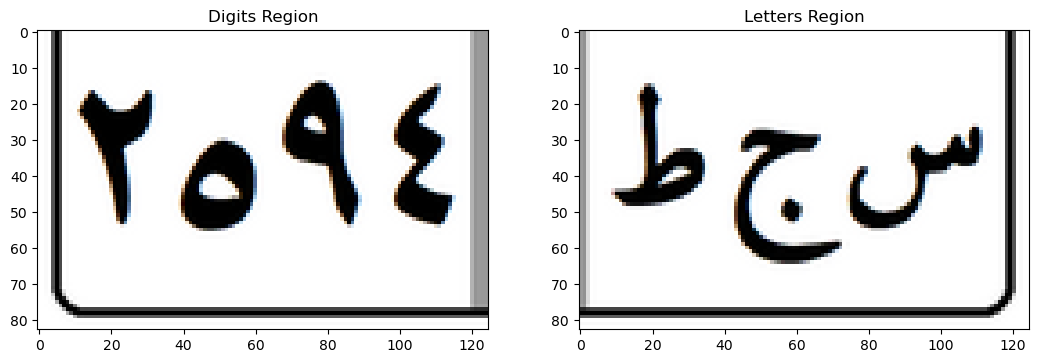

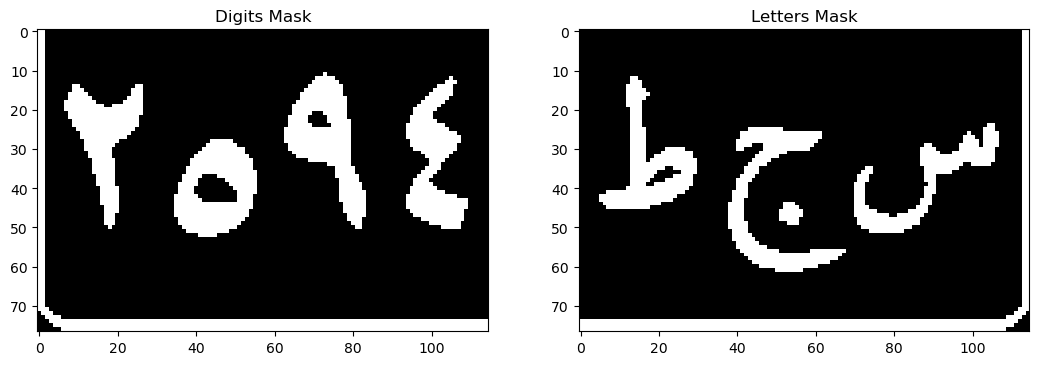

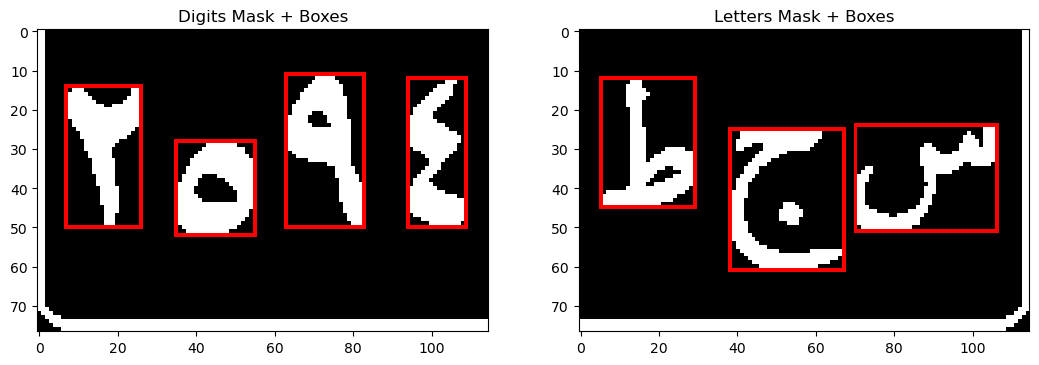

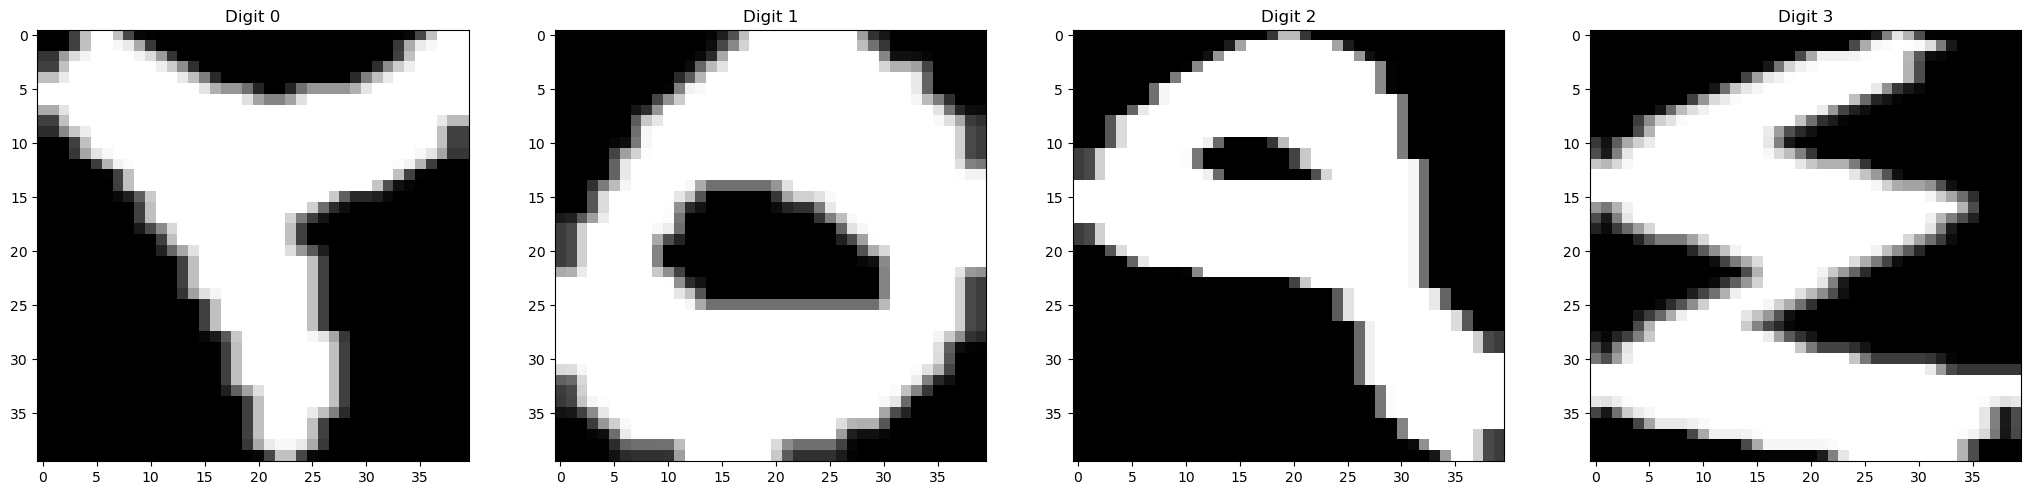

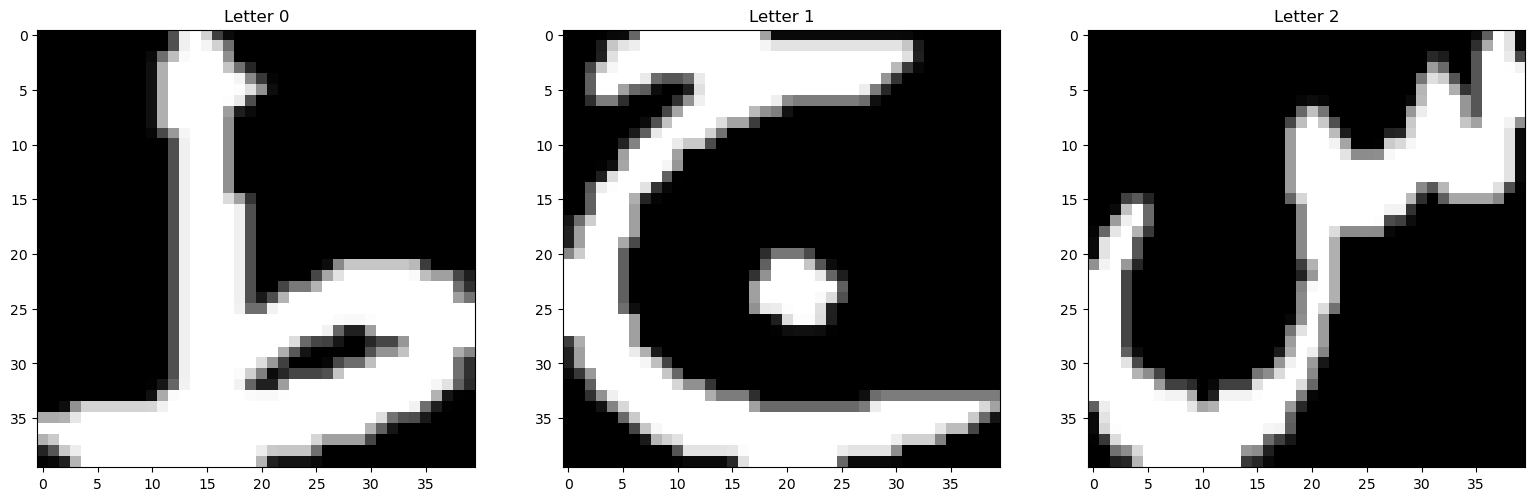

'\nMAAW FORTNITE BATTLE ROYALE\n'

In [8]:
'''
MAAW FORTNITE BATTLE ROYALE
'''




import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_holes,
    remove_small_objects,
    binary_closing,
    square,
)
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.color import gray2rgb



# ---------------------------------------------------
# 1) SIMPLE GEOMETRIC UTILITIES
# ---------------------------------------------------

def crop_bottom(img, top_ratio=0.40):
    """
    Keep the lower part of the plate (digits + letters).
    top_ratio is the fraction of height we cut from the top.
    """
    h, w = img.shape[:2]
    return img[int(h * top_ratio):, :]


def split_digits_letters(bottom):
    """
    Egyptian plate: digits on the left half, letters on the right half.
    """
    h, w = bottom.shape[:2]
    mid = w // 2
    return bottom[:, :mid], bottom[:, mid:]


def get_mask(region):
    gray = rgb2gray(region)

    T = threshold_otsu(gray)
    mask = gray < T

    # ✅ KEEP holes & dots (light cleaning only)
    mask = remove_small_objects(mask, 25)

    return mask





# ---------------------------------------------------
# 2) DIGITS EXTRACTION
# ---------------------------------------------------
#0.01
def touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.005):
    mr = int(margin_ratio * H)
    mc = int(margin_ratio * W)

    if r0 <= mr: return True        # top
    if c0 <= mc: return True        # left
    if r1 >= H - mr: return True    # bottom
    if c1 >= W - mc: return True    # right

    return False



def extract_digits(digits_region, max_chars=4, debug=False):
    H0, W0 = digits_region.shape[:2]
    border_ratio = 0.04
    by = int(border_ratio * H0)
    bx = int(border_ratio * W0)
    sub = digits_region[by:H0 - by, bx:W0 - bx]


    
    mask = get_mask(sub)
    H, W = mask.shape

    # Kill thin border noise so it doesn’t attach to digits
    #mask[:10, :] = 0
    #mask[-10:, :] = 0
    #mask[:, :5] = 0
    #mask[:, -5:] = 0


    lbl = label(mask)

    candidates = []
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox
        '''
        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue
        '''
        touches = touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.01)

        if touches:
            h = r1 - r0
            w = c1 - c0
            ar = p.area / (H * W)

            # ✅ only reject if it looks like a FRAME, not a digit
            if h > 0.9 * H or w < 0.02 * W or ar < 0.002:
                continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        wr = w / W
        ar = area / (H * W)
        '''
        if wr < 0.08 or wr > 0.60:
            continue
        #if ar < 0.01:
        if ar < 0.002:
            continue
        '''
        if wr < 0.035 or wr > 0.75:
            continue

        if ar < 0.001:
            continue

        candidates.append({"bbox": [r0, c0, r1, c1], "area": area})

    candidates.sort(key=lambda c: c["bbox"][1])

    merged = []
    for c in candidates:
        if not merged:
            merged.append(c)
            continue

        r0, c0, r1, c1 = c["bbox"]
        r0m, c0m, r1m, c1m = merged[-1]["bbox"]
        overlap_x = min(c1, c1m) - max(c0, c0m)

        if overlap_x > 0:
            merged[-1]["bbox"] = [
                min(r0, r0m), min(c0, c0m),
                max(r1, r1m), max(c1, c1m)
            ]
        else:
            merged.append(c)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    chars = []
    for m in merged:
        r0, c0, r1, c1 = m["bbox"]
        #if (r1 - r0) < 0.40 * H:
        if (r1 - r0) < 0.22 * H:
            continue

        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # crop = mask[r0:r1, c0:c1].astype(float)
        chars.append((c0 + bx, crop))

    chars.sort(key=lambda x: x[0])

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]



# ---------------------------------------------------
# 3) LETTERS EXTRACTION
# ---------------------------------------------------

def extract_letters(letters_region, max_chars=3, debug=False):
    H0, W0 = letters_region.shape[:2]
    by = int(0.04 * H0)
    bx = int(0.04 * W0)
    sub = letters_region[by:H0 - by, bx:W0 - bx]

    mask = get_mask(sub)
    H, W = mask.shape
    lbl = label(mask)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    big_blobs = []   # main letter bodies
    small_blobs = [] # dots

    # -----------------------------
    # 1) SPLIT BIG BLOBS & DOTS
    # -----------------------------
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue
    


        h = r1 - r0
        w = c1 - c0
        area = p.area
        cy = p.centroid[0] / H
        wr = w / W
        ar = area / (H * W)
        '''
        # REMOVE VERTICAL BORDER
        margin = int(0.02 * H)
        if r0 <= margin and r1 >= H - margin:
            continue
        '''


        # 👉 DOT = any small area < 0.015
        if ar < 0.015:
            small_blobs.append((r0, c0, r1, c1))
            continue

        # 👉 MAIN LETTER FILTER (no lower area limit now)
        if wr < 0.08 or wr > 0.75:
            continue
        if ar > 0.22:
            continue
        if cy > 0.75:
            continue

        big_blobs.append([r0, c0, r1, c1])


    # -----------------------------------------
    # 2) ATTACH EACH DOT TO NEAREST LETTER BOX
    # -----------------------------------------
    for dr0, dc0, dr1, dc1 in small_blobs:
        dc = (dc0 + dc1) / 2
        dr = (dr0 + dr1) / 2

        best_i = -1
        best_dx = 1e9

        for i, box in enumerate(big_blobs):
            r0, c0, r1, c1 = box
            bc = (c0 + c1) / 2
            br = (r0 + r1) / 2

            dx = abs(dc - bc)
            dy = abs(dr - br)

            # ✅ must be vertically close AND horizontally closest
            if dx < best_dx and dy < 120:
                best_dx = dx
                best_i = i

        # ✅ attach dot ONLY to the nearest valid letter
        if best_i != -1:
            box = big_blobs[best_i]
            box[0] = min(box[0], dr0)
            box[1] = min(box[1], dc0)
            box[2] = max(box[2], dr1)
            box[3] = max(box[3], dc1)


        # if dot wasn't matched, safely ignore it

    # -----------------------------------------
    # 3) SORT & CROP FINAL LETTERS
    # -----------------------------------------
    big_blobs.sort(key=lambda b: b[1])

    chars = []
    for r0, c0, r1, c1 in big_blobs:
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # crop = mask[r0:r1, c0:c1].astype(float)
        chars.append((c0 + bx, crop))

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]



# ---------------------------------------------------
# 4) FULL PIPELINE FOR ONE IMAGE
# ---------------------------------------------------
def process_plate(img):
    bottom = crop_bottom(img)
    digits_region, letters_region = split_digits_letters(bottom)

    digits, d_mask, d_boxes = extract_digits(digits_region, debug=True)
    letters, l_mask, l_boxes = extract_letters(letters_region, debug=True)

    return digits_region, letters_region, digits, letters, d_mask, d_boxes, l_mask, l_boxes


# img22 = imread('Q1.jpg')
# img22 = imread('Dataset/Buses & government vehicles.png')
# img22 = imread('Dataset/Diplomatic vehicles.png')
#img22 = imread('Dataset/image.png')
img22 = imread('Dataset/Limousines & tourist buses.png')
#img22 = imread('Dataset/Police vehicles.png')
#img22 = rgba2rgb(imread('Dataset/Private vehicles & motorcycles.png'))
#img22 = rgba2rgb(imread('Dataset/Taxis.png'))
#img22 = imread('Dataset/Trucks.png')
#img22 = imread('Dataset/Vehicles with unpaid customs.png')

def save_characters(digits, letters):
    # Save digits
    for i, img in enumerate(digits):
        out = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        cv2.imwrite(f"digit_{i}.png", out)

    # Save letters
    for i, img in enumerate(letters):
        out = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        cv2.imwrite(f"letter_{i}.png", out)



d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(img22)
# d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(Detected_Plate1)
#problem in plate_crop2 and plate_crop3

# ---- Regions ----
show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])

# ---- Masks ----
show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])

# ---- Masks with Bounding Boxes ----
show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

# ---- Final Cropped Digits ----
digit_titles = [f"Digit {i}" for i in range(len(digits))]
show_images(digits, digit_titles)

# ---- Final Cropped Letters ----
letter_titles = [f"Letter {i}" for i in range(len(letters))]
show_images(letters, letter_titles)

save_characters(digits,letters)




'''
MAAW FORTNITE BATTLE ROYALE
'''


In [9]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os

western_to_arabic = {
    0: '٠', 1: '١', 2: '٢', 3: '٣', 4: '٤',
    5: '٥', 6: '٦', 7: '٧', 8: '٨', 9: '٩'
}

# -------------------------------
# NORMALIZATION
# -------------------------------
def normalize_digit(img):
    img = img.copy()

    if np.mean(img) > 127:
        img = cv2.bitwise_not(img)

    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return cv2.resize(img, (64, 64))

    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    img = img[y0:y1+1, x0:x1+1]

    img = cv2.copyMakeBorder(img, 12, 12, 12, 12,
                              cv2.BORDER_CONSTANT, value=0)

    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
    return img.astype(np.uint8)

# -------------------------------
# MULTI-TEMPLATE VOTING MATCHER
# -------------------------------
def match_digit(img, refs_folder="digits_reference"):
    img = normalize_digit(img)

    scores = {}

    for d in range(10):
        digit_folder = os.path.join(refs_folder, str(d))
        if not os.path.exists(digit_folder):
            continue

        best_local = -1

        for fname in os.listdir(digit_folder):
            ref = cv2.imread(os.path.join(digit_folder, fname), 0)
            ref = normalize_digit(ref)

            score = ssim(img, ref)
            best_local = max(best_local, score)

        scores[d] = best_local

    # ✅ pick digit with strongest template match
    best_digit = max(scores, key=scores.get)

    return best_digit

# -------------------------------
# CLASSIFICATION
# -------------------------------
final_digits_western = []
final_digits_arabic  = []

for d in digits:
    d_img = (d * 255).astype(np.uint8)
    digit = match_digit(d_img)

    final_digits_western.append(str(digit))
    final_digits_arabic.append(western_to_arabic[digit])

# -------------------------------
# FINAL OUTPUT
# -------------------------------
print("\n✅ FINAL PLATE (ARABIC): ", "".join(final_digits_arabic))
print("✅ FINAL PLATE (WESTERN):", "".join(final_digits_western))



✅ FINAL PLATE (ARABIC):  ٢٩٨٦
✅ FINAL PLATE (WESTERN): 2986


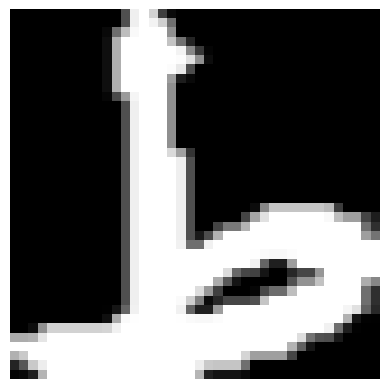

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected Arabic digit EASYOCR: ['ا']


c:\Users\Ahmed\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [10]:
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
os.environ['TESSDATA_PREFIX'] = os.path.abspath("Dataset")
# os.environ.pop('TESSDATA_PREFIX', None)
def add_padding(img, pad=10):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

def add_paddingblack(img, pad=50):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )


def pad_for_easyocr(img):
    h, w = img.shape
    new_img = np.zeros((h, w*3), dtype=np.uint8)  # black background
    new_img[:, w:w*2] = img  # center the character
    return new_img


def recognize_arabic_digit(image_path, show_preprocessed=False):
    """
    Recognize a single Arabic digit from an image.
    
    Args:
        image_path (str): Path to image file.
        show_preprocessed (bool): If True, shows the binary preprocessed image.
    
    Returns:
        str: Detected Arabic digit or empty string if not recognized.
    """
    
    # 1. Load image
    img = io.imread(image_path)
    # img=add_paddingblack(img)
    # img=pad_for_easyocr(img)
    
    # img=add_padding(img)
    # img=d_mask
    if img.dtype == bool:
        img = (img * 255).astype(np.uint8)

    # # Ensure grayscale, not weird format
    # if len(img.shape) == 2:
    #     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # # 2. Convert to grayscale if needed
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    
    # # 3. Resize image up to help OCR
    # gray = cv2.resize(gray, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    
    # # 4. Smooth image to reduce noise
    # blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # # 5. Threshold to get binary image
    # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # 6. Invert if background is dark
    # if np.mean(thresh) < 127:
    #     thresh = cv2.bitwise_not(thresh)
    
    # # Optional: show preprocessed image
    if show_preprocessed:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # 7. Configure Tesseract for single character + Arabic digits only
    # config = f'--oem 3 --psm 10 -c tessedit_char_whitelist={ARABIC_DIGITS}'
    
    # 8. Run OCR
    # text = pytesseract.image_to_string(thresh, lang='ara')

    reader = easyocr.Reader(['ar'])
    results = reader.readtext(img)
    texts = [text for bbox, text, prob in results]


    # 9. Clean result
    # text = text.strip()
    return texts

# Example usage:
digit = recognize_arabic_digit("letter_0.png", show_preprocessed=True)
print("Detected Arabic digit EASYOCR:", repr(digit))
# print("Detected Arabic digit:", repr(digit))


Using CPU. Note: This module is much faster with a GPU.


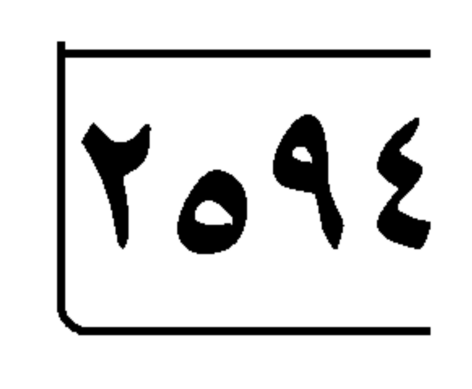

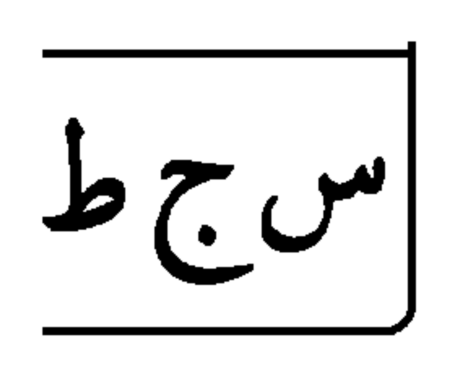

digit_0: '_'
letter_0: 'م'


In [11]:
import easyocr
import cv2
import numpy as np

reader = easyocr.Reader(['ar'], gpu=False)  # make this global or at module level

def prepare_for_easyocr_char(img):
    """
    img: numpy array (grayscale or RGB) containing ONE character.
    Returns a padded, upscaled image suitable for EasyOCR.
    """

    # If bool -> uint8
    if img.dtype == bool:
        img = (img * 255).astype(np.uint8)

    # Convert to grayscale
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = img.astype(np.uint8)

    # Normalize range
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)

    # Binarize a bit to stabilize
    _, img = cv2.threshold(img, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Make sure text is dark on light (helps EasyOCR)
    if img.mean() < 127:      # mostly dark => likely white on black
        img = 255 - img       # invert to black text on white

    # ---- FIX #1: add margin so glyph doesn't touch borders ----
    border = 20
    img = cv2.copyMakeBorder(
        img, border, border, border, border,
        borderType=cv2.BORDER_CONSTANT,
        value=255  # white background
    )

    # ---- FIX #2: upscale ----
    img = cv2.resize(img, None, fx=5, fy=5,
                     interpolation=cv2.INTER_LINEAR)

    return img


def recognize_single_char_easyocr(image_path, show=False):
    # load from file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    prep = prepare_for_easyocr_char(img)

    if show:
        import matplotlib.pyplot as plt
        plt.imshow(prep, cmap='gray')
        plt.axis('off'); plt.show()

    # detail=0 -> just texts; paragraph=False so it doesn't merge things
    texts = reader.readtext(prep, detail=0, paragraph=False)

    return texts[0] if texts else ""

digit0 = recognize_single_char_easyocr("clean_digits.png", show=True)
letter0 = recognize_single_char_easyocr("clean_letters.png", show=True)
print("digit_0:", repr(digit0))
print("letter_0:", repr(letter0))


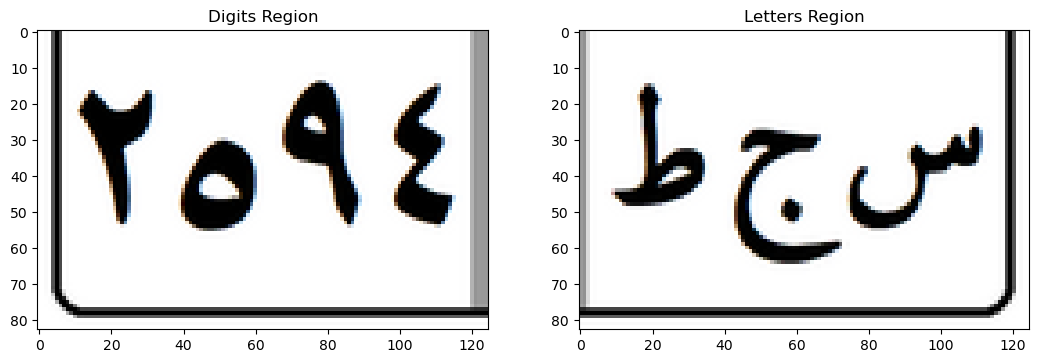

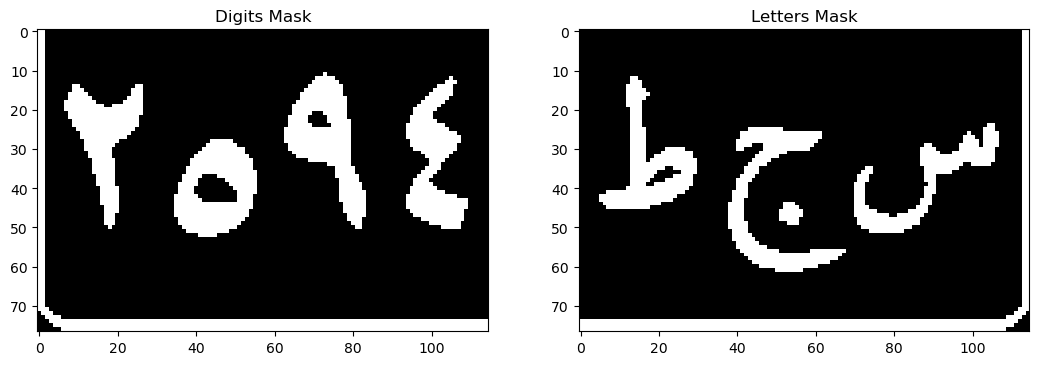

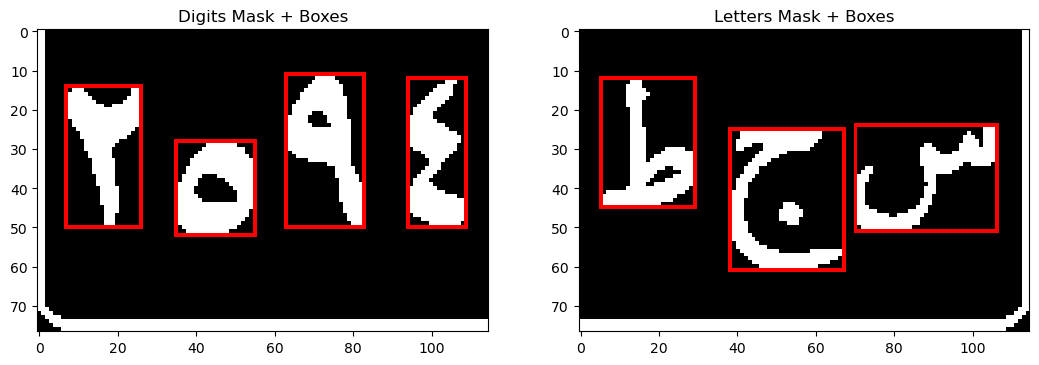

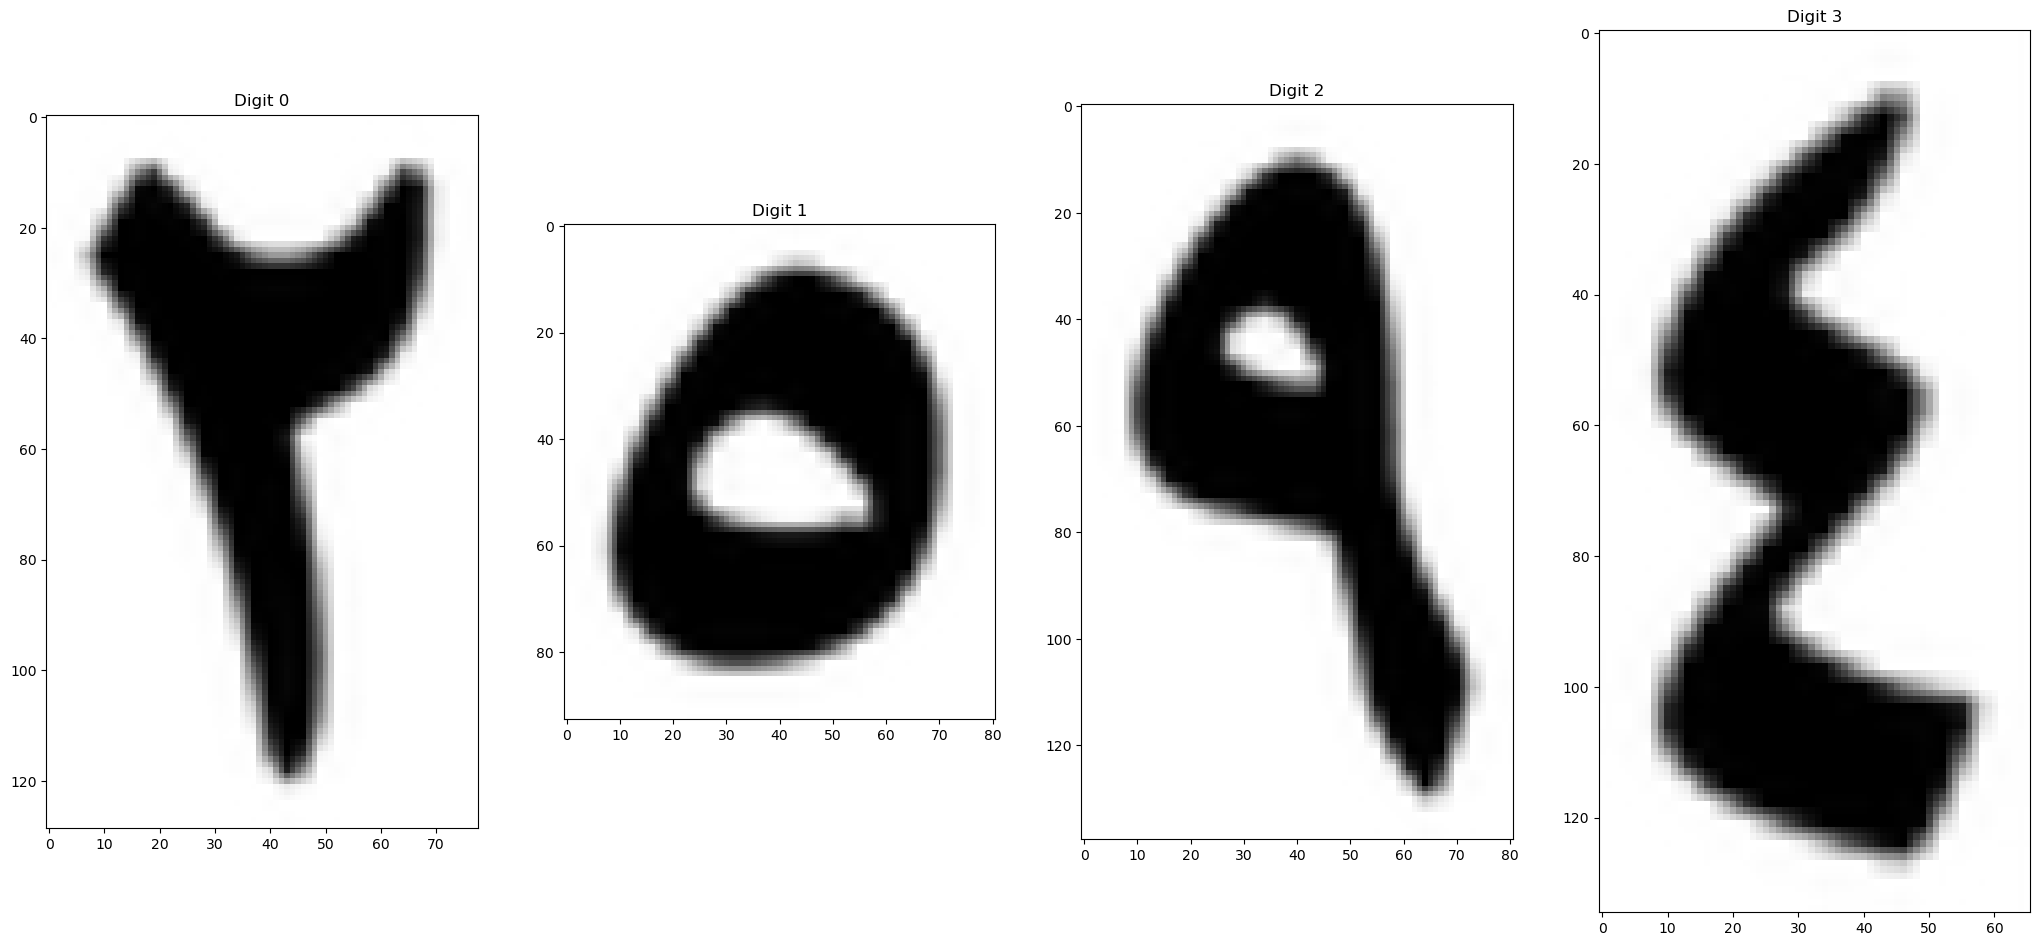

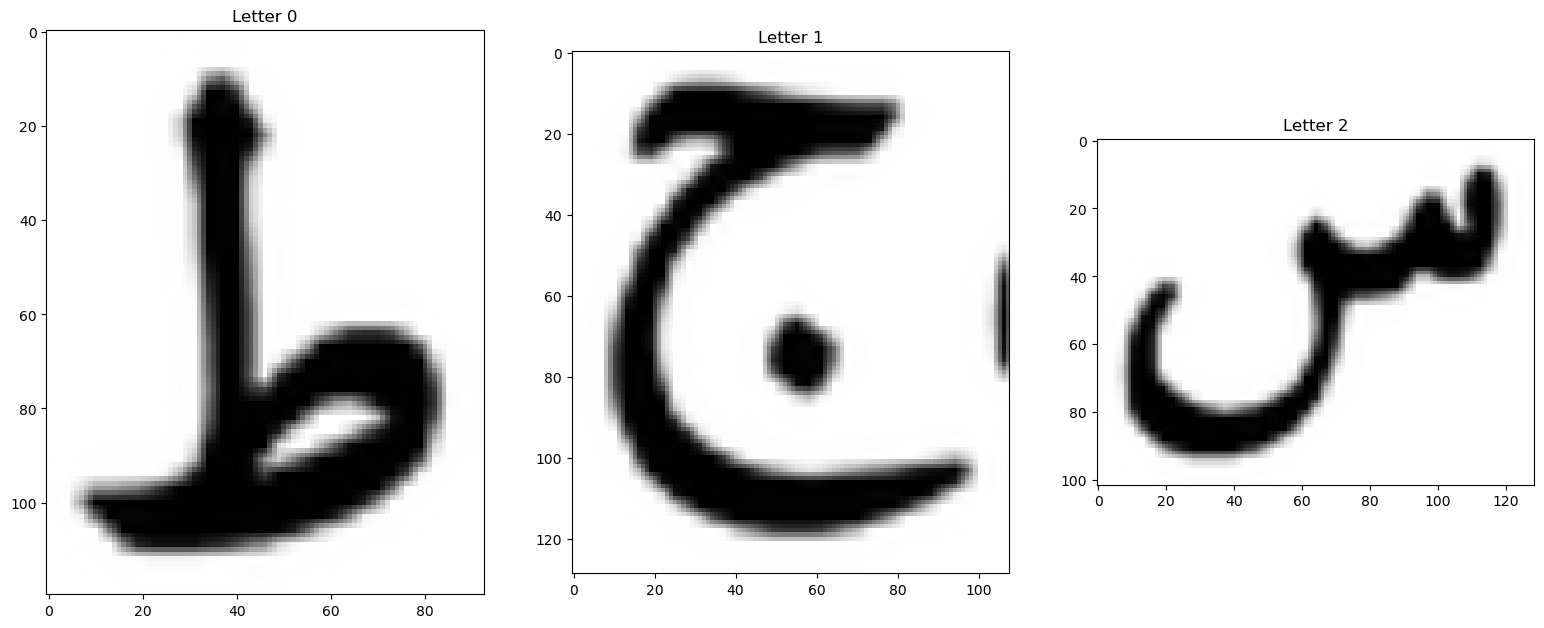

In [12]:
'''
MAAW FORTNITE BATTLE ROYALE
'''

import numpy as np
import matplotlib.pyplot as plt
import cv2                         ### <<< you were using cv2 in save_characters

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_holes,
    remove_small_objects,
    binary_closing,
    square,
)
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.color import gray2rgb


# ---------------------------------------------------
# 1) SIMPLE GEOMETRIC UTILITIES
# ---------------------------------------------------

def crop_bottom(img, top_ratio=0.40):
    """
    Keep the lower part of the plate (digits + letters).
    top_ratio is the fraction of height we cut from the top.
    """
    h, w = img.shape[:2]
    return img[int(h * top_ratio):, :]


def split_digits_letters(bottom):
    """
    Egyptian plate: digits on the left half, letters on the right half.
    """
    h, w = bottom.shape[:2]
    mid = w // 2
    return bottom[:, :mid], bottom[:, mid:]


def get_mask(region):
    gray = rgb2gray(region)
    T = threshold_otsu(gray)
    mask = gray < T

    # ✅ KEEP holes & dots (light cleaning only)
    mask = remove_small_objects(mask, 25)
    return mask


# ---------------------------------------------------
# Helper: create a crop that is friendly for OCR
# ---------------------------------------------------
def make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                       pad=3, scale=3):
    """
    gray_sub : grayscale version of sub-image (0–1)
    (r0,c0,r1,c1) : bbox in sub coordinates
    pad : extra pixels around character
    scale : upscaling factor (so text is not tiny)
    """
    H, W = gray_sub.shape

    rr0 = max(r0 - pad, 0)
    cc0 = max(c0 - pad, 0)
    rr1 = min(r1 + pad, H)
    cc1 = min(c1 + pad, W)

    crop = gray_sub[rr0:rr1, cc0:cc1]        # 0–1 float from rgb2gray

    # upscale (don’t DOWNsize to 40×40)
    h, w = crop.shape
    crop = resize(crop, (int(h * scale), int(w * scale)),
                  anti_aliasing=True)

    return crop   # still float 0–1


# ---------------------------------------------------
# 2) DIGITS EXTRACTION
# ---------------------------------------------------

def touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.005):
    mr = int(margin_ratio * H)
    mc = int(margin_ratio * W)

    if r0 <= mr: return True        # top
    if c0 <= mc: return True        # left
    if r1 >= H - mr: return True    # bottom
    if c1 >= W - mc: return True    # right

    return False


def extract_digits(digits_region, max_chars=4, debug=False):
    H0, W0 = digits_region.shape[:2]
    border_ratio = 0.04
    by = int(border_ratio * H0)
    bx = int(border_ratio * W0)
    sub = digits_region[by:H0 - by, bx:W0 - bx]

    # segmentation is done on mask
    mask = get_mask(sub)
    gray_sub = rgb2gray(sub)          ### <<< NEW: grayscale for OCR crops
    H, W = mask.shape

    lbl = label(mask)

    candidates = []
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        touches = touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.01)
        if touches:
            h = r1 - r0
            w = c1 - c0
            ar = p.area / (H * W)
            # ✅ only reject if it looks like a FRAME, not a digit
            if h > 0.9 * H or w < 0.02 * W or ar < 0.002:
                continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        wr = w / W
        ar = area / (H * W)

        if wr < 0.035 or wr > 0.75:
            continue
        if ar < 0.001:
            continue

        candidates.append({"bbox": [r0, c0, r1, c1], "area": area})

    # sort left → right
    candidates.sort(key=lambda c: c["bbox"][1])

    # merge overlapping boxes
    merged = []
    for c in candidates:
        if not merged:
            merged.append(c)
            continue

        r0, c0, r1, c1 = c["bbox"]
        r0m, c0m, r1m, c1m = merged[-1]["bbox"]
        overlap_x = min(c1, c1m) - max(c0, c0m)

        if overlap_x > 0:
            merged[-1]["bbox"] = [
                min(r0, r0m), min(c0, c0m),
                max(r1, r1m), max(c1, c1m)
            ]
        else:
            merged.append(c)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    chars = []
    for m in merged:
        r0, c0, r1, c1 = m["bbox"]
        if (r1 - r0) < 0.22 * H:
            continue

        # draw box for debug
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        # <<< OLD:
        # crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # chars.append((c0 + bx, crop))

        # >>> NEW: OCR-friendly grayscale crop with padding + upscaling
        crop = make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                                  pad=3, scale=3)
        chars.append((c0 + bx, crop))

    chars.sort(key=lambda x: x[0])

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]


# ---------------------------------------------------
# 3) LETTERS EXTRACTION
# ---------------------------------------------------

def extract_letters(letters_region, max_chars=3, debug=False):
    H0, W0 = letters_region.shape[:2]
    by = int(0.04 * H0)
    bx = int(0.04 * W0)
    sub = letters_region[by:H0 - by, bx:W0 - bx]

    mask = get_mask(sub)
    gray_sub = rgb2gray(sub)            ### <<< NEW: grayscale for OCR crops
    H, W = mask.shape
    lbl = label(mask)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    big_blobs = []   # main letter bodies
    small_blobs = [] # dots

    # -----------------------------
    # 1) SPLIT BIG BLOBS & DOTS
    # -----------------------------
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        cy = p.centroid[0] / H
        wr = w / W
        ar = area / (H * W)

        # 👉 DOT = any small area < 0.015
        if ar < 0.015:
            small_blobs.append((r0, c0, r1, c1))
            continue

        # 👉 MAIN LETTER FILTER (no lower area limit now)
        if wr < 0.08 or wr > 0.75:
            continue
        if ar > 0.22:
            continue
        if cy > 0.75:
            continue

        big_blobs.append([r0, c0, r1, c1])

    # -----------------------------------------
    # 2) ATTACH EACH DOT TO NEAREST LETTER BOX
    # -----------------------------------------
    for dr0, dc0, dr1, dc1 in small_blobs:
        dc = (dc0 + dc1) / 2
        dr = (dr0 + dr1) / 2

        best_i = -1
        best_dx = 1e9

        for i, box in enumerate(big_blobs):
            r0, c0, r1, c1 = box
            bc = (c0 + c1) / 2
            br = (r0 + r1) / 2

            dx = abs(dc - bc)
            dy = abs(dr - br)

            # ✅ must be vertically close AND horizontally closest
            if dx < best_dx and dy < 120:
                best_dx = dx
                best_i = i

        # ✅ attach dot ONLY to the nearest valid letter
        if best_i != -1:
            box = big_blobs[best_i]
            box[0] = min(box[0], dr0)
            box[1] = min(box[1], dc0)
            box[2] = max(box[2], dr1)
            box[3] = max(box[3], dc1)

    # -----------------------------------------
    # 3) SORT & CROP FINAL LETTERS
    # -----------------------------------------
    big_blobs.sort(key=lambda b: b[1])

    chars = []
    for r0, c0, r1, c1 in big_blobs:
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        # <<< OLD:
        # crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # chars.append((c0 + bx, crop))

        # >>> NEW: grayscale + padding + upscaling
        crop = make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                                  pad=3, scale=3)
        chars.append((c0 + bx, crop))

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]


# ---------------------------------------------------
# 4) FULL PIPELINE FOR ONE IMAGE
# ---------------------------------------------------
def process_plate(img):
    bottom = crop_bottom(img)
    digits_region, letters_region = split_digits_letters(bottom)

    digits, d_mask, d_boxes = extract_digits(digits_region, debug=True)
    letters, l_mask, l_boxes = extract_letters(letters_region, debug=True)

    return digits_region, letters_region, digits, letters, d_mask, d_boxes, l_mask, l_boxes


# Choose your plate image
img22 = imread('Dataset/Limousines & tourist buses.png')

def save_characters(digits, letters):
    # digits / letters are floats 0–1 → uint8 0–255
    for i, img in enumerate(digits):
        out = (img * 255).astype(np.uint8)
        cv2.imwrite(f"digit_{i}.png", out)

    for i, img in enumerate(letters):
        out = (img * 255).astype(np.uint8)
        cv2.imwrite(f"letter_{i}.png", out)


d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(img22)

# (show_images assumed defined elsewhere)
show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])
show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])
show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

digit_titles = [f"Digit {i}" for i in range(len(digits))]
show_images(digits, digit_titles)

letter_titles = [f"Letter {i}" for i in range(len(letters))]
show_images(letters, letter_titles)

save_characters(digits, letters)
